# Question 1 (50 points)
This first question will serve as an introduction to working with modAL in order to implement some of the basic active learning concepts we have covered thus far in lecture. This includes pool-based sampling, as well as query by committee. Conveniently, modAL includes the ActiveLearner and Committee classes, which helps make both of these steps simpler. You will be required to instantiate the appropriate objects using these classes, utilize modAL supported query strategies, as well as implement one of your own. In doing so, you will perform some of your first active learning experiments, and report the results as asked below. You are provided with an imaging data set “Data.csv”. This data comprises 500 samples each with 26 features. Each sample is labeled with one of ten possible subcellular locations. You are also given the Jupyter Notebook template for completing this assignment. Notice the cell below will load and partition the data for you. 
\textbf{Complete the code under \#\#\#TO DO in each cell and produce the required plots.} Feel free to define any helper functions as you see fit. You may import and use any modules in scikit-learn and NumPy to help with your implementations (modAL is built specifically to support and mimic scikit-learn functionality)

In [1]:
import numpy as np
import pandas as pd 
import matplotlib.pyplot as plt
import copy

### modAL 
from modAL.models import ActiveLearner, Committee 
from modAL.density import information_density
from modAL.uncertainty import classifier_uncertainty, uncertainty_sampling
from modAL.disagreement import max_disagreement_sampling, vote_entropy_sampling
from sklearn.neighbors import KNeighborsClassifier

### sklearn
from sklearn.preprocessing import LabelEncoder, normalize
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
from sklearn.linear_model import LogisticRegression


### Suppresses Warning
import warnings
warnings.filterwarnings('ignore')


### Set randome seed
seed = 10 
np.random.seed(seed)

## Reading and Processing the Data

In [2]:
data = pd.read_csv('data/q1/Data.csv')
X = data.iloc[:,:26].values
y = LabelEncoder().fit_transform(data.iloc[:,-1])

X_training, y_training = [], []
for i in range(10):
    unique_label_idx = list(y).index(i)
    xx = X[unique_label_idx]
    X_training.append(xx)
    y_training.append(i)
    X, y = np.delete(X, unique_label_idx, axis=0), np.delete(y, unique_label_idx, axis=0)

X_pool, X_test, y_pool, y_test = train_test_split(X,y,test_size=0.5,random_state=seed)

X_training = np.asarray(X_training)
y_training = np.asarray(y_training)

# Part 0. Review for logistical regression and random forest (0 pt.)
In this problem we are going to test different Querry strategies on two types of machine learning algorims: Logistic Regression and Random forest. We can see the classification accuracy for both models in supervised learning setting in the cell below. If labels are abundent and classes are well-seprated in feature space, the classifiers can classify the different classes with high acuracy.

In [3]:
N_estimator_rf = 20
MAX_depth_rf = 6

lr = LogisticRegression()
lr.fit(X_pool, y_pool)

rf = RandomForestClassifier(n_estimators = N_estimator_rf, 
                            max_depth = MAX_depth_rf, random_state = seed)
rf.fit(X_pool, y_pool)

print('Accuracy of logistic regression: \t{:.3f}'.format(lr.score(X_test,y_test)))
print('Accuracy of random forest: \t\t{:.3f}'.format(rf.score(X_test,y_test)))

Accuracy of logistic regression: 	0.898
Accuracy of random forest: 		0.861


# 1.1: Random Sampling (5 pts. total) 

Complete the code under ###TO DO in the following cell. Create a random_query() function that provide a method for randomly selecting a sample to query from the oracle, and must be consistent with the query methods expected by modAL when called. $\textbf{Do not change the random seed}$. Perform random sampling for 100 calls to the oracle with each ActiveLearner. After each call to the oracle, measure the accuracy of each learner on predictions across the test sets (X_test and y_test). Report the final accuracy and make a plot with query number as the x-axis, and accuracy as the y-axis (one single plot with four curves, one for each sampling method. Some code is provided that you may use if you want). 

$\textbf{Hint}$: Check the <a href="https://modal-python.readthedocs.io/en/latest/index.html"> modAL documentation</a> for how to call an ActiveLearner. Within the documentation, check the Extending modAL section for a tutorial on implementing a custom query strategy.

In [4]:
def random_query(classifier, X, a_keyword_argument=42):
    query_idx = np.random.choice(range(X.shape[0]))
    return np.array(query_idx), X[query_idx]

## Logistic Regression (2.5 pts.)
Use logistic regression as estimator to your active learner.

In [5]:
X_pool_rand_lr = copy.deepcopy(X_pool)
y_pool_rand_lr = copy.deepcopy(y_pool)

history_rand_lr = []
lr_learner = ActiveLearner(
    estimator = LogisticRegression(),
    query_strategy = random_query,
    X_training=X_training, y_training=y_training,
)
for i in range(100):
    query_idx, query_sample = lr_learner.query(X_pool_rand_lr)
    query_label = y_pool_rand_lr[query_idx.reshape(1)]
    lr_learner.teach(query_sample.reshape(1,-1), query_label)
    X_pool_rand_lr,  y_pool_rand_lr= np.delete(X_pool_rand_lr, query_idx, axis=0), np.delete(y_pool_rand_lr, query_idx, axis=0)
    history_rand_lr.append(lr_learner.score(X_test,y_test))

## Plot classification accuracy with respect to number of labels queried

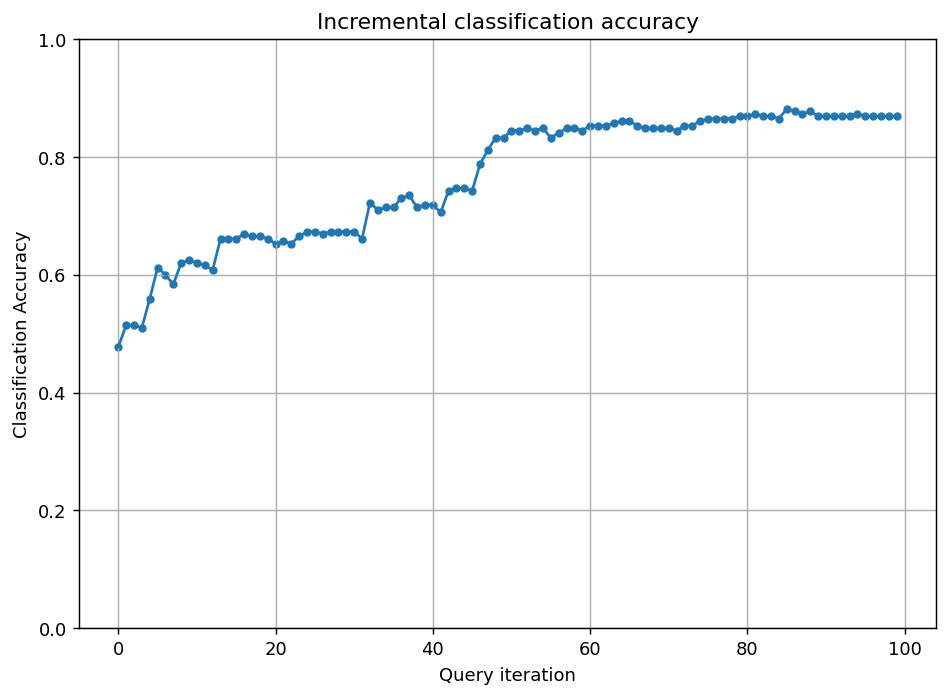

In [6]:
# Plot our performance over time.
fig, ax = plt.subplots(figsize=(8.5, 6), dpi=130)

ax.plot(history_rand_lr)
ax.scatter(range(len(history_rand_lr)), history_rand_lr, s=13)

ax.set_ylim(bottom=0, top=1)
ax.grid(True)

ax.set_title('Incremental classification accuracy')
ax.set_xlabel('Query iteration')
ax.set_ylabel('Classification Accuracy')

plt.show()

## Random Forest (2.5 pts.)

Use random forest as estimator to your active learner. Use 20 estimators with max depth of 6 and the seed the random forsest classifier with the same seed above.

In [7]:
X_pool_rand_rf = copy.deepcopy(X_pool)
y_pool_rand_rf = copy.deepcopy(y_pool)

history_rand_rf = []

rf_learner = ActiveLearner(
    estimator = RandomForestClassifier(n_estimators = N_estimator_rf, 
                            max_depth = MAX_depth_rf, random_state = seed),
    query_strategy = random_query,
    X_training=X_training, y_training=y_training,
)

for i in range(100):
    query_idx, query_sample = rf_learner.query(X_pool_rand_rf)
    query_label = y_pool_rand_rf[query_idx.reshape(1)]
    X_pool_rand_rf,  y_pool_rand_rf= np.delete(X_pool_rand_rf, query_idx, axis=0), np.delete(y_pool_rand_rf, query_idx, axis=0)
    rf_learner.teach(query_sample.reshape(1,-1), query_label)
    history_rand_rf.append(rf_learner.score(X_test,y_test))

## Plot classification accuracy with respect to number of labels queried

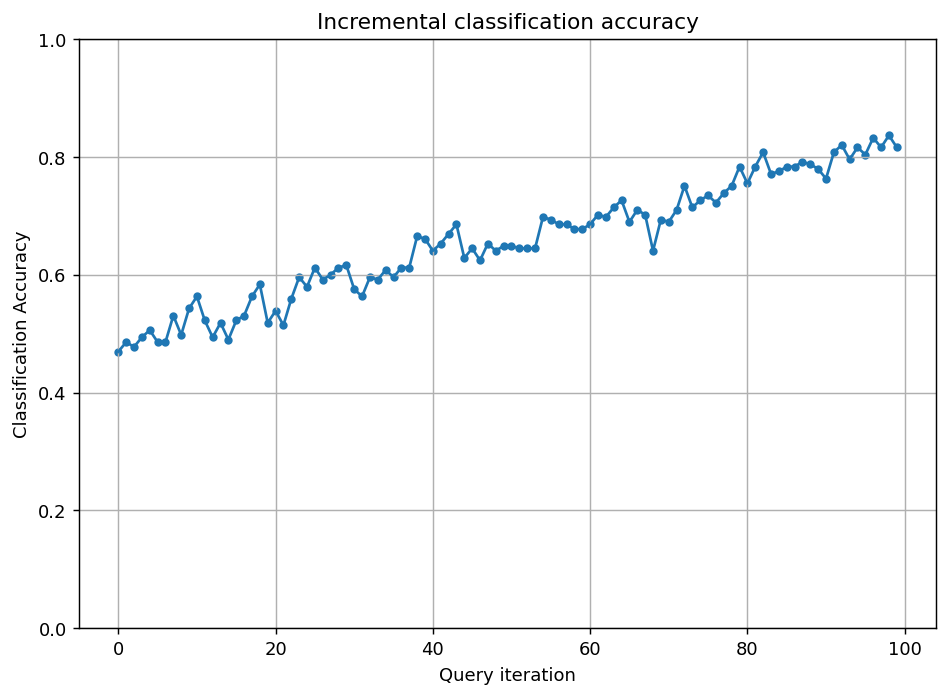

In [8]:
# Plot our performance over time.
fig, ax = plt.subplots(figsize=(8.5, 6), dpi=130)

ax.plot(history_rand_rf)
ax.scatter(range(len(history_rand_rf)), history_rand_rf, s=13)

ax.set_ylim(bottom=0, top=1)
ax.grid(True)

ax.set_title('Incremental classification accuracy')
ax.set_xlabel('Query iteration')
ax.set_ylabel('Classification Accuracy')

plt.show()

# 1-2. Uncertainty Sampling (15 pts. total)
Create an ActiveLearner with <a href="https://modal-python.readthedocs.io/en/latest/content/query_strategies/uncertainty_sampling.html">Uncertainty sampling</a> as the sampling strategy for each of the estimator below. Report the final accuracy and plot the classification accuracy with respect to number of labels queried for both the uncertainty and random sampling for each estimator.

## Logistic Regression (7.5 pts.)

In [9]:
X_pool_uncert_lr = copy.deepcopy(X_pool)
y_pool_uncert_lr = copy.deepcopy(y_pool)


history_uncert_lr = []
uncert_lr_learner = ActiveLearner(
    estimator = LogisticRegression(),
    query_strategy = uncertainty_sampling,
    X_training=X_training, y_training=y_training,
)
for i in range(100):
    query_idx, query_sample = uncert_lr_learner.query(X_pool_uncert_lr)
    query_label = y_pool_uncert_lr[query_idx]
    X_pool_uncert_lr,  y_pool_uncert_lr= np.delete(X_pool_uncert_lr, query_idx, axis=0), np.delete(y_pool_uncert_lr, query_idx, axis=0)
    uncert_lr_learner.teach(query_sample, query_label)
    history_uncert_lr.append(uncert_lr_learner.score(X_test,y_test))

## Plot classification accuracy with respect to number of labels queried

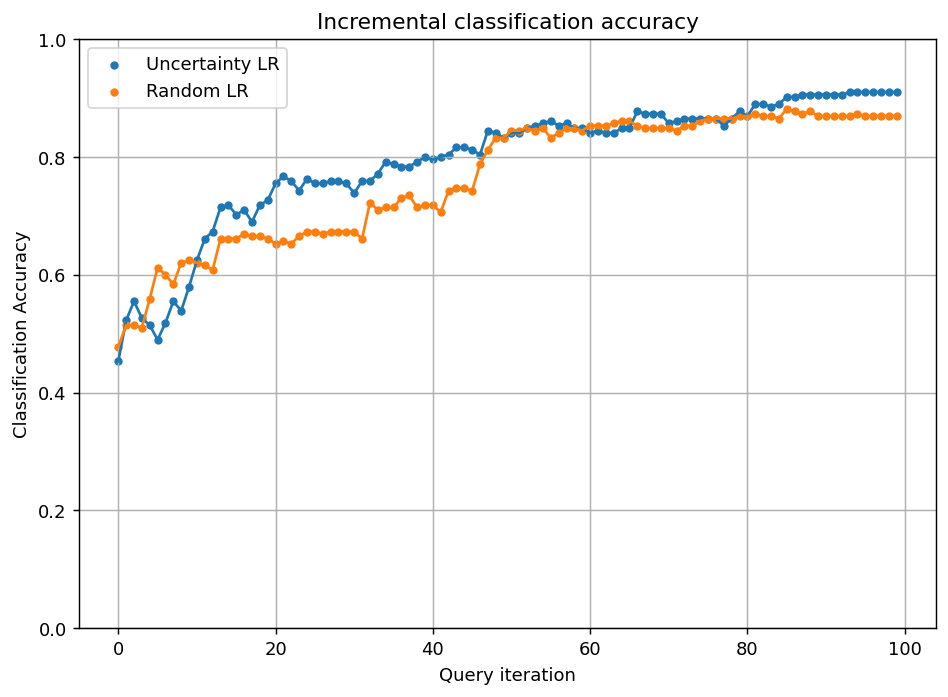

In [10]:
# Plot our performance over time.
fig, ax = plt.subplots(figsize=(8.5, 6), dpi=130)

ax.plot(history_uncert_lr)
ax.scatter(range(len(history_uncert_lr)), history_uncert_lr, s=13, label = 'Uncertainty LR')

ax.plot(history_rand_lr)
ax.scatter(range(len(history_rand_lr)), history_rand_lr, s=13, label = 'Random LR')

ax.set_ylim(bottom=0, top=1)
ax.grid(True)

ax.set_title('Incremental classification accuracy')
ax.set_xlabel('Query iteration')
ax.set_ylabel('Classification Accuracy')

ax.legend()

plt.show()

## Random Forest (7.5 pts.)

In [11]:
X_pool_uncert_rf = copy.deepcopy(X_pool)
y_pool_uncert_rf = copy.deepcopy(y_pool)

history_uncert_rf = []

uncert_rf_learner = ActiveLearner(
    estimator = RandomForestClassifier(n_estimators = N_estimator_rf, 
                            max_depth = MAX_depth_rf, random_state = seed),
    query_strategy = uncertainty_sampling,
    X_training=X_training, y_training=y_training,
)

for i in range(100):
    query_idx, query_sample = uncert_rf_learner.query(X_pool_uncert_rf)
    query_label = y_pool_uncert_rf[query_idx]
    X_pool_uncert_rf,  y_pool_uncert_rf= np.delete(X_pool_uncert_rf, query_idx, axis=0), np.delete(y_pool_uncert_rf, query_idx, axis=0)
    uncert_rf_learner.teach(query_sample, query_label)
    history_uncert_rf.append(uncert_rf_learner.score(X_test,y_test))

## Plot Classification Accuracy with respect to number of labels queried

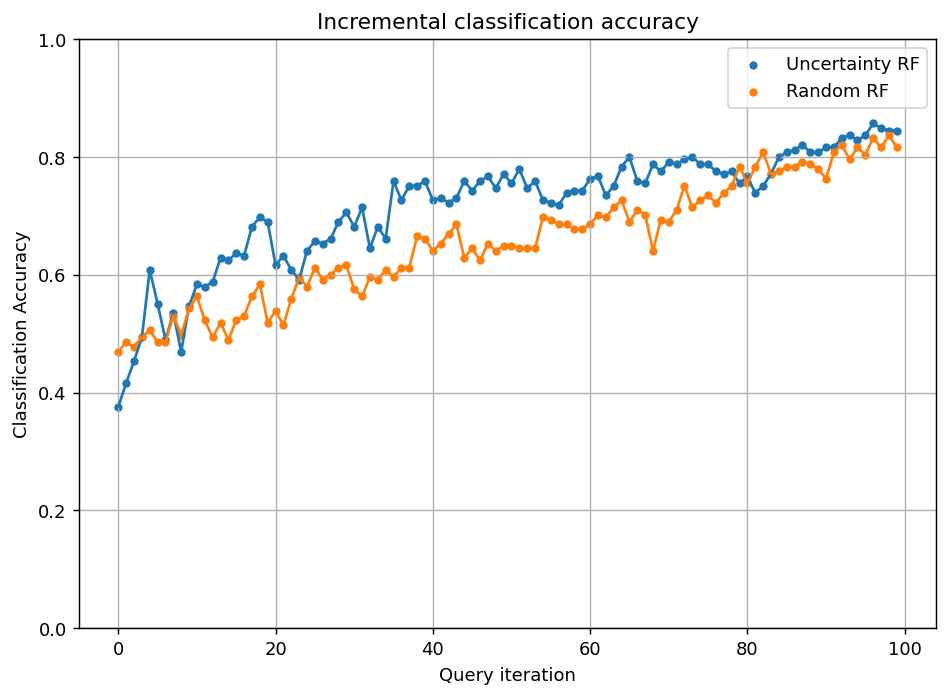

In [12]:
# Plot our performance over time.
fig, ax = plt.subplots(figsize=(8.5, 6), dpi=130)

ax.plot(history_uncert_rf)
ax.scatter(range(len(history_uncert_rf)), history_uncert_rf, s=13, label = 'Uncertainty RF')

ax.plot(history_rand_rf)
ax.scatter(range(len(history_rand_rf)), history_rand_rf, s=13, label = 'Random RF')

ax.set_ylim(bottom=0, top=1)
ax.grid(True)

ax.set_title('Incremental classification accuracy')
ax.set_xlabel('Query iteration')
ax.set_ylabel('Classification Accuracy')

ax.legend()

plt.show()

# 1.3: Density based sampling  (15 pts. total)
Create an ActiveLearner with <a href="https://modal-python.readthedocs.io/en/latest/content/query_strategies/information_density.html">information density</a> for each of the estimator below. Use Euclidean metric for similarity and uncertainity for utility function. Set $\beta$ = 1. Report the final accuracy and plot the classification accuracy with respect to number of labels queried for both the uncertainty and random sampling for each estimator.

## Logistic regression (7.5 pts.)

In [13]:
def density_query(classifier, X, a_keyword_argument=42):
    # measure the utility of each instance in the pool
    
    utility = classifier_uncertainty(classifier, X)
    utility *= information_density(X, 'euclidean')

    # select the indices of the instances to be queried
    query_idx = np.argsort(utility)[-1]

    # return the indices and the instances
    return np.array(query_idx), X[query_idx]

In [14]:
X_pool_dens_lr = copy.deepcopy(X_pool)
y_pool_dens_lr = copy.deepcopy(y_pool)

history_dens_lr = []
dens_lr_learner = ActiveLearner(
    estimator = LogisticRegression(),
    query_strategy = density_query,
    X_training=X_training, y_training=y_training,
)
for i in range(100):
    query_idx, query_sample = dens_lr_learner.query(X_pool_dens_lr)
    query_label = y_pool_dens_lr[query_idx.reshape(1)]
    X_pool_dens_lr,  y_pool_dens_lr= np.delete(X_pool_dens_lr, query_idx, axis=0), np.delete(y_pool_dens_lr, query_idx, axis=0)
    dens_lr_learner.teach(query_sample.reshape(1,-1), query_label)
    history_dens_lr.append(dens_lr_learner.score(X_test,y_test))

## Plot Classification Accuracy with respect to number of labels queried

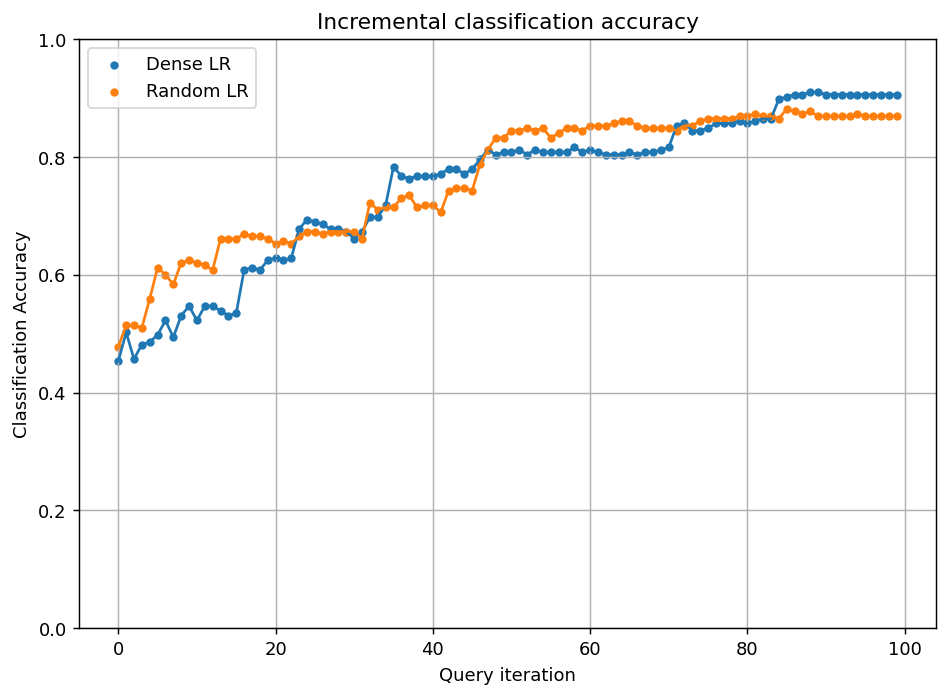

In [15]:
# Plot our performance over time.
fig, ax = plt.subplots(figsize=(8.5, 6), dpi=130)

ax.plot(history_dens_lr)
ax.scatter(range(len(history_dens_lr)), history_dens_lr, s=13, label = 'Dense LR')

ax.plot(history_rand_lr)
ax.scatter(range(len(history_rand_lr)), history_rand_lr, s=13, label = 'Random LR')

ax.set_ylim(bottom=0, top=1)
ax.grid(True)

ax.set_title('Incremental classification accuracy')
ax.set_xlabel('Query iteration')
ax.set_ylabel('Classification Accuracy')
ax.legend()
plt.show()

## Random Forest (7.5 pts.)

In [16]:
X_pool_dens_rf = copy.deepcopy(X_pool)
y_pool_dens_rf = copy.deepcopy(y_pool)


history_dens_rf = []

### TODO
dens_rf_learner = ActiveLearner(
    estimator = RandomForestClassifier(n_estimators = N_estimator_rf, 
                            max_depth = MAX_depth_rf, random_state = seed),
    query_strategy = density_query,
    X_training=X_training, y_training=y_training,
)

for i in range(100):
    query_idx, query_sample = dens_rf_learner.query(X_pool_dens_rf)
    query_label = y_pool_dens_rf[query_idx.reshape(1)]
    X_pool_dens_rf,  y_pool_dens_rf= np.delete(X_pool_dens_rf, query_idx, axis=0), np.delete(y_pool_dens_rf, query_idx, axis=0)
    dens_rf_learner.teach(query_sample.reshape(1,-1), query_label)
    history_dens_rf.append(dens_rf_learner.score(X_test,y_test))

## Plot Classification Accuracy with respect to number of labels queried

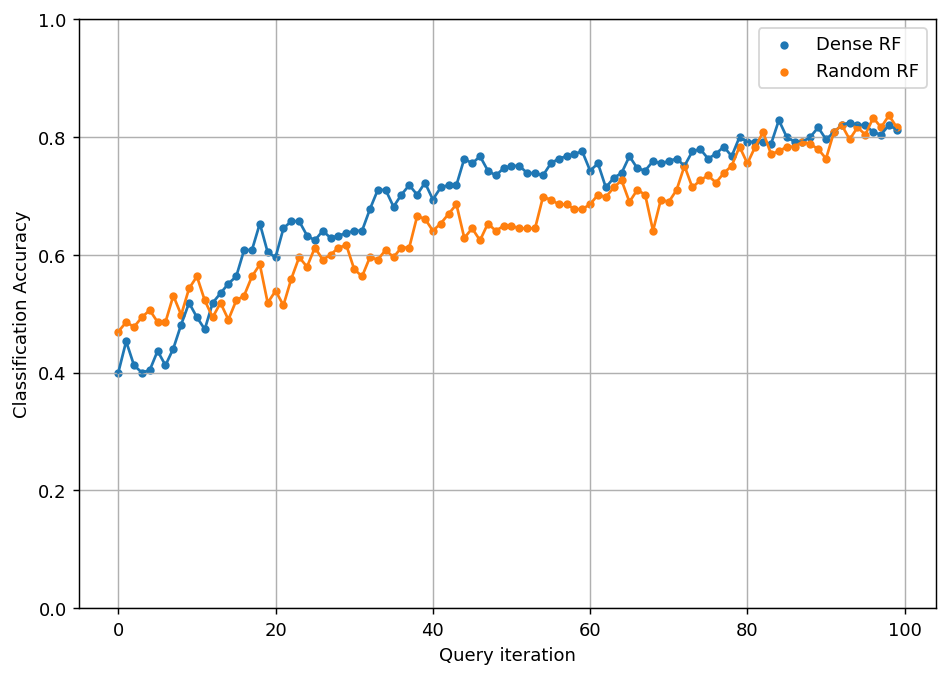

In [17]:
# Plot our performance over time.
fig, ax = plt.subplots(figsize=(8.5, 6), dpi=130)

ax.plot(history_dens_rf)
ax.scatter(range(len(history_dens_rf)), history_dens_rf, s=13, label = 'Dense RF')

ax.plot(history_rand_rf)
ax.scatter(range(len(history_rand_rf)), history_rand_rf, s=13, label = 'Random RF')

ax.set_ylim(bottom=0, top=1)
ax.grid(True)

ax.set_xlabel('Query iteration')
ax.set_ylabel('Classification Accuracy')
ax.legend()

plt.show()

# 1.4: Query-By-Committee with max disagreement sampling   (10 pts. total)

Finally, we will now use modAL to implement query by committee. We will form a committee with <a href="https://modal-python.readthedocs.io/en/latest/content/query_strategies/Disagreement-sampling.html">max disagreement</a> sampling. Within modAL, forming a committee is as easy as creating a list of ActiveLearners, and passing this along with the query method to Committee(). The Committee object can then be used exactly as the ActiveLearner objects we used in the previous parts (eg. Use Committee.query(X,y) or Committee.teach(X,y), etc.). Construct the committee described above, with logistic regression classifier as the first member and random forest as the second. As in the previous section, perform 100 queries to the oracle, and plot number of queries against prediction accuracy across the test sets and compare with both the random forest and logistic regression classifier with random sampling strategy.

In [18]:
X_pool_comm = copy.deepcopy(X_pool)
y_pool_comm = copy.deepcopy(y_pool)

history_comm = []

### TODO
learner_list = [None] * 2
learner_list[0] =  ActiveLearner(
        estimator=LogisticRegression(),
        query_strategy=max_disagreement_sampling,
        X_training=X_training, y_training=y_training)

learner_list[1] = ActiveLearner(
    estimator = RandomForestClassifier(n_estimators = N_estimator_rf, 
                            max_depth = MAX_depth_rf, random_state = seed),
    query_strategy = max_disagreement_sampling,
    X_training=X_training, y_training=y_training,
)
# assembling the committee
committee = Committee(learner_list=learner_list)
for i in range(100):
    query_idx, query_sample = committee.query(X_pool_comm)
    query_label = y_pool_comm[query_idx]
    committee.teach(query_sample, query_label)
    X_pool_comm,  y_pool_comm= np.delete(X_pool_comm, query_idx, axis=0), np.delete(y_pool_comm, query_idx, axis=0)
    history_comm.append(committee.score(X_test,y_test))

## Plot Classification Accuracy with respect to number of labels queried

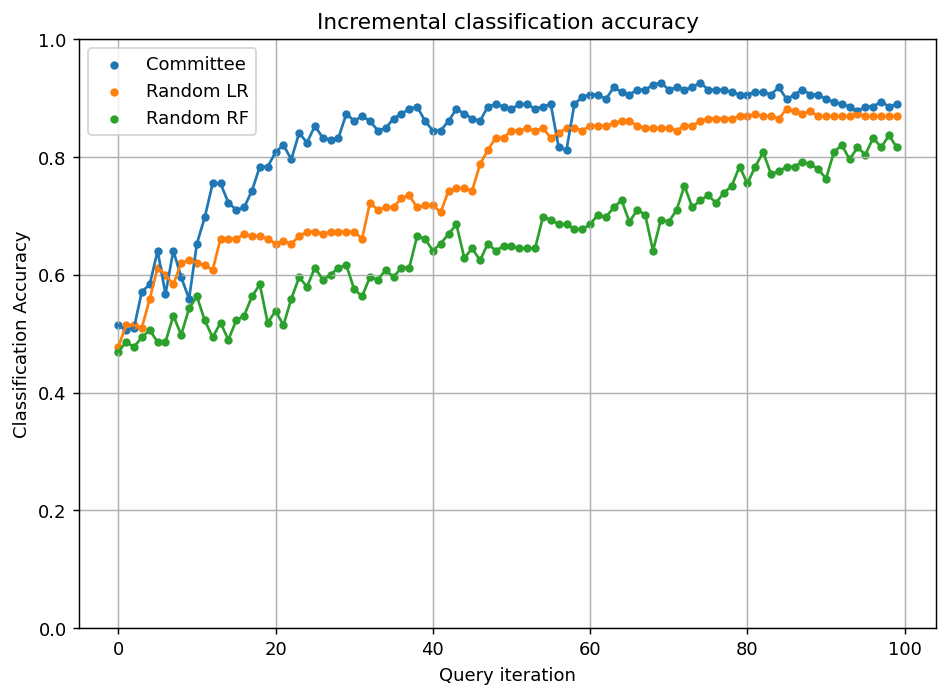

In [19]:
# Plot our performance over time.
fig, ax = plt.subplots(figsize=(8.5, 6), dpi=130)


ax.plot(history_comm)
ax.scatter(range(len(history_comm)), history_comm, s=13, label = 'Committee')


ax.plot(history_rand_lr)
ax.scatter(range(len(history_rand_lr)), history_rand_lr, s=13, label = 'Random LR')

ax.plot(history_rand_rf)
ax.scatter(range(len(history_rand_rf)), history_rand_rf, s=13, label = 'Random RF')

ax.set_ylim(bottom=0, top=1)
ax.grid(True)


ax.set_title('Incremental classification accuracy')
ax.set_xlabel('Query iteration')
ax.set_ylabel('Classification Accuracy')
ax.legend()
plt.show()